In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchvision import datasets, transforms
#from complexPyTorch.complexLayers import ComplexBatchNorm2d, ComplexConv2d, ComplexLinear
#from complexPyTorch.complexLayers import ComplexDropout2d, NaiveComplexBatchNorm2d
#from complexPyTorch.complexLayers import ComplexBatchNorm1d
#from complexPyTorch.complexFunctions import complex_relu, complex_max_pool2d

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, peak_widths

import cvnn.layers as complex_layers

In [2]:
X = np.genfromtxt('C:/Users/alamg/Documents/MATLAB/Thesis/X_v3.csv', delimiter=',')
Y_c = pd.read_csv('C:/Users/alamg/Desktop/Thesis_ML/matlab/S11_data.csv')
Y = np.genfromtxt('C:/Users/alamg/Documents/MATLAB/Thesis/Targets_v3.csv', delimiter=',')

In [3]:
Y_c.shape

(101, 3848)

In [4]:
w1= np.arange(0,3848,1)  
w2=np.arange(0,101,1)
w3=np.linspace(1,101,101)
dP1 = []
dP2 = []
dP3 = []
dA1 = []
dA2 = []
dA3 = []
dQ1 = []
dQ2 =[]
dQ3= []
pos1 = []
pos2 = []
pos3 = []
x_2p_data= pd.DataFrame()
y_2p_data = pd.DataFrame()

In [5]:
##extracting peaks, Q-factor, amp from data
for i in w1:
    peaks, _ = find_peaks(Y[i,:],height=0.4)
    if len(peaks)==1:
      dP1.append(peaks)
      dA1.append(Y[i,(peaks[0])])
      j = peak_widths(Y[i,:], peaks, rel_height=0.5)
      dQ1.append(j[0])
      pos1.append(i)  
    if len(peaks)==2:
        dP2.append(peaks)
        dA2.append(Y[i,(peaks[0],peaks[1])])
        j = peak_widths(Y[i,:], peaks, rel_height=0.5)
        dQ2.append(j[0])
        pos2.append(i) 
    if len(peaks)==3:
        dP3.append(peaks)
        dA3.append(Y[i,(peaks[0],peaks[1],peaks[2])])
        j = peak_widths(Y[i,:], peaks, rel_height=0.5)
        dQ3.append(j[0])
        pos3.append(i)

In [6]:
pos2[2]

5

In [7]:
##extracting 2 peaks responses 
y_2p_wav = []

                                                                                                                            
#getting full waveform for 2 peaks responses
for i in range(0,len(pos2)):
    j = pos2[i]
    y_2p_wav.append(Y[j,:])

y_2p_wav = np.array(y_2p_wav)

z = pd.DataFrame(y_2p_wav)

y_2p_wav.shape

(2087, 101)

In [21]:
#converting pandas to numpy 
Y_c = Y_c.to_numpy()
Y_c = Y_c.T


In [167]:
#extracting 2 peaks for complex data 
y_2p_com=[]                                                                                                         
#getting full waveform for 2 peaks responses
for i in range(0,len(pos2)):
    j = pos2[i]
    y_2p_com.append(Y_c[j][:])

In [169]:
y_2p_com = np.array(y_2p_com, dtype=np.complex64)

In [170]:
y_2p_com.shape

(2087, 101)

In [27]:
#Getting x data as pandas frame 
x_2p_data = pd.DataFrame()
#getting data for each peak response by taking X as different pos values for each 1,2,3 peak response
for i in range(0,len(pos2)):
    j = pos2[i]
    k = pd.DataFrame({"P1":X[j,0],"H1":X[j,1],"H2":X[j,2],"H3":X[j,3],"W1":X[j,4]},index=[i])
    x_2p_data = pd.concat([x_2p_data, pd.DataFrame(k)], ignore_index=True)

In [28]:
x_2p_data_c = x_2p_data.values.astype(np.complex64)

In [29]:
x_2p_data.head

<bound method NDFrame.head of             P1        H1        H2        H3        W1
0     0.092773  0.161133  0.819336  0.170898  0.430664
1     0.695801  0.854004  0.190918  0.034668  0.794434
2     0.384277  0.665527  0.955566  0.896973  0.525879
3     0.034668  0.409668  0.320801  0.266113  0.734863
4     0.144775  0.390381  0.643311  0.885498  0.577881
...        ...       ...       ...       ...       ...
2082  0.664885  0.505430  0.989183  0.470556  0.642668
2083  0.131681  0.362852  0.205980  0.917822  0.449308
2084  0.097502  0.731016  0.968676  0.049658  0.670988
2085  0.390348  0.556089  0.225145  0.187719  0.870085
2086  0.828581  0.841002  0.067186  0.111792  0.763395

[2087 rows x 5 columns]>

In [142]:
Y_real, Y_imag = np.real(y_2p_com), np.imag(y_2p_com)

In [108]:
Y_all = np.concatenate((Y_real, Y_imag), axis=1)

In [174]:
Y_imag

array([[-0.19279893, -0.47473097,  0.21201833, ..., -0.41324914,
        -0.5065162 , -0.5888266 ],
       [-0.5990586 , -0.15926316,  0.3240427 , ...,  0.0250001 ,
         0.12450028,  0.2216887 ],
       [ 0.4453756 , -0.00388974, -0.44205415, ..., -0.6126512 ,
        -0.5747867 , -0.52370447],
       ...,
       [ 0.6309044 ,  0.18079588, -0.34297124, ..., -0.65134937,
        -0.6300484 , -0.590995  ],
       [-0.15217426, -0.6933919 , -0.86656165, ..., -0.8351015 ,
        -0.8039345 , -0.76002526],
       [-0.13992521,  0.2785296 ,  0.6186539 , ...,  0.15658501,
         0.253537  ,  0.34662893]], dtype=float32)

In [46]:
input_shape = (5,)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(x_2p_data,y_2p_com, test_size=0.2, random_state=42)

In [137]:
y_2p_com.shape

(2087, 101)

In [117]:
#complex ANN
from cvnn.losses import ComplexMeanSquareError

model = tf.keras.models.Sequential()
#model.add(complex_layers.ComplexDense(complex_layers.ComplexInput(input_shape=input_shape[1:]), activation='cart_relu'))
model.add(complex_layers.ComplexInput(input_shape=input_shape))
model.add(complex_layers.ComplexFlatten())
model.add(complex_layers.ComplexDense(units=32, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=64, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=64, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=64, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=64, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=101, activation='linear'))
model.compile( loss=ComplexMeanSquareError(), optimizer='adam')

In [118]:
model.summary()

model.fit(X_train, y_train, epochs=1000, batch_size=32)  # Replace X_train and Y_train with your actual training data

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_flatten_1 (Complex  (None, 5)                 0         
 Flatten)                                                        
                                                                 
 complex_dense_6 (ComplexDe  (None, 32)                384       
 nse)                                                            
                                                                 
 complex_dense_7 (ComplexDe  (None, 64)                4224      
 nse)                                                            
                                                                 
 complex_dense_8 (ComplexDe  (None, 64)                8320      
 nse)                                                            
                                                                 
 complex_dense_9 (ComplexDe  (None, 64)               

In [119]:
predictions = model.predict(X_test)

14/14 [==============================] - 0s 2ms/step


In [120]:
#geting absorbance from predicted
abs_pred=[]
for i in range(len(predictions)):
    row = []
    for j in range(len(predictions[0])):
        # Calculate the desired value and append it to the row list
        value = 1 - (abs(predictions[i][j]) ** 2)
        row.append(value)
    # Append the row list to abs_pred
    abs_pred.append(row)

In [133]:
#calculating absorbance of test data
abs_y=[]
for i in range(len(y_test)):
    row = []
    for j in range(len(y_test[0])):
        # Calculate the desired value and append it to the row list
        value = 1 - (abs(y_test[i,j]) ** 2)
        row.append(value)
    # Append the row list to abs_pred
    abs_y.append(row)

In [154]:
#absolute for predicted
pred_abs_d = abs(predictions)

In [163]:
#absolute for ytest
y_test_abs= abs(y_test)

In [145]:
pred_real= predictions.real
pred_comp= predictions.imag

pred_real.shape

(418, 101)

In [147]:
pred_all = np.concatenate((pred_real, pred_comp), axis=1)
pred_all.shape

(418, 202)

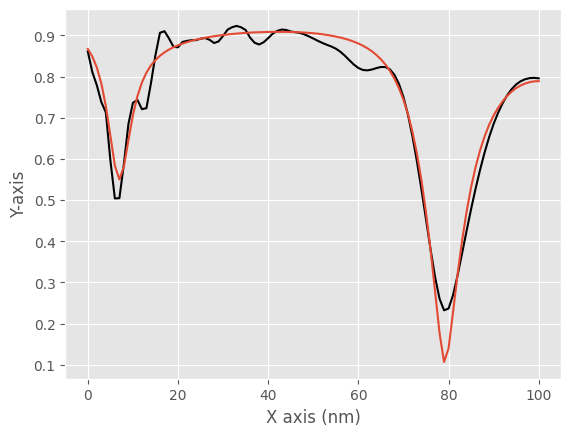

In [165]:
#plotting of absolute data
w4=np.arange(0,101,1)
with plt.style.context('ggplot'): #sanity check if correct waveforms are loaded
    plt.plot(w4,pred_abs_d[0,:],label='complex', color='black')
    plt.plot(w4,y_test_abs[0,:], label='absorbance')
    #plt.plot(w3,y_2p_wav[1,:])
    plt.xlabel("X axis (nm)")
    plt.ylabel("Y-axis")
    plt.show()
   # plt.legend()

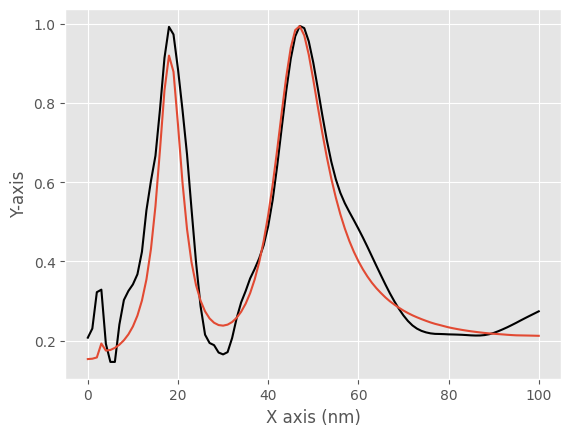

In [136]:
#absorbance reconstructed from predicted data
w4=np.arange(0,101,1)
with plt.style.context('ggplot'): #sanity check if correct waveforms are loaded
    plt.plot(w4,abs_pred[1][:],label='complex', color='black')
    plt.plot(w4,abs_y[1][:], label='absorbance')
    #plt.plot(w3,y_2p_wav[1,:])
    plt.xlabel("X axis (nm)")
    plt.ylabel("Y-axis")
    plt.show()
   # plt.legend()

In [76]:
#w4=np.arange(0,100,1)
#with plt.style.context('ggplot'): #sanity check if correct waveforms are loaded
#    plt.plot(w4,y_2p_com.imag[1,:])
#    plt.plot(w4,predictions.imag[1][:], color = 'black')
#    #plt.plot(w3,y_2p_wav[1,:])
#    plt.xlabel("X axis (nm)")
#    plt.ylabel("Y-axis")
#    plt.show()

In [75]:
#y_testp = y_test[:,0:2] #for plotting different Qfactor etc..
#predictionsp = predictions[:,0:2]

#y_testA = y_test[:,2:4]
#predictionsA = predictions[:,2:4]

#y_testq = y_test[:,4:6]
#predictionsq = predictions[:,4:6]

In [78]:
#non complex model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [84]:

# Assuming X and Y are your feature and target matrices respectively
# Split the data into training and testing sets
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(x_2p_data,Y_all, test_size=0.2, random_state=42)


# Now X_test contains the testing data
# You can use this X_test to evaluate your trained model

# Create a Sequential model
model_2 = Sequential()

# Add the input layer and the first hidden layer
model_2.add(Dense(32, input_shape=(5,), activation='relu'))  # Assuming 64 neurons in the first hidden layer

# Add additional hidden layers if needed
model_2.add(Dense(64, activation='relu'))  # Example of adding another hidden layer

# Add additional hidden layers if needed
model_2.add(Dense(64, activation='relu'))  # Example of adding another hidden layer

# Add additional hidden layers if needed
model_2.add(Dense(64, activation='relu'))  # Example of adding another hidden layer

# Add additional hidden layers if needed
model_2.add(Dense(64, activation='relu'))  # Example of adding another hidden layer

# Add the output layer
model_2.add(Dense(202, activation='linear'))  # Assuming 5 design parameters, using linear activation

# Compile the model
model_2.compile(optimizer='adam', loss='mse')  # Using mean squared error as the loss function

# Print a summary of the model
model_2.summary()

# Train the model
model_2.fit(X_train_m2, y_train_m2, epochs=1000, batch_size=32)  # Replace X_train and Y_train with your actual training data


# Make predictions
predictions_m2 = model_2.predict(X_test_m2)  # Replace X_test with your actual test data




Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                192       
                                                                 
 dense_11 (Dense)            (None, 64)                2112      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 202)               13130     
                                                                 
Total params: 27914 (109.04 KB)
Trainable params: 2791

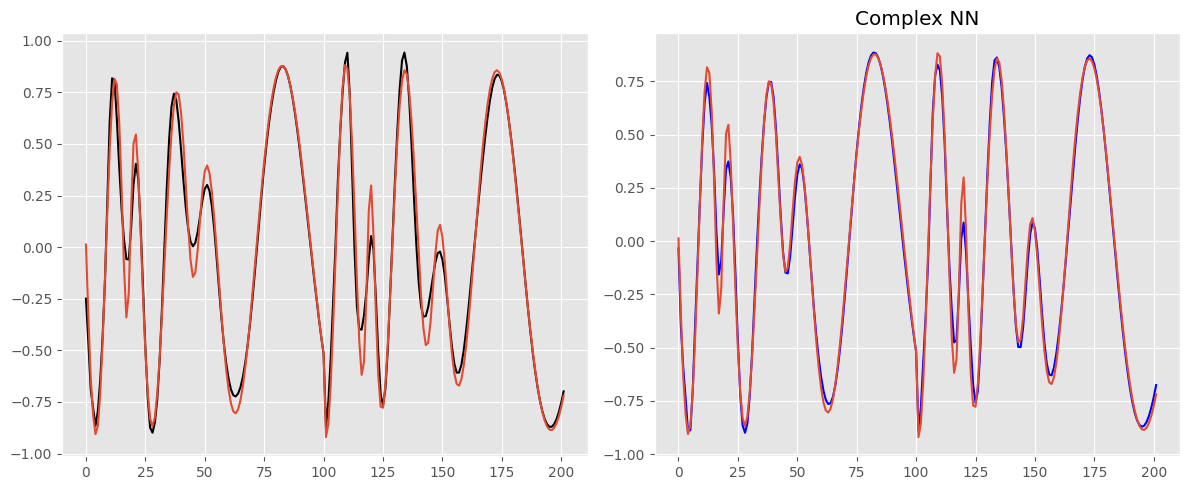

In [153]:
w4=np.arange(0,202,1)
with plt.style.context('ggplot'):#sanity check if correct waveforms are loaded
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
   # plt.subplot(1, 2, 1) 
    
    axs[0].plot(w4,predictions_m2[1,:],label='complex', color='black')
    axs[0].plot(w4,y_test_m2[1,:], label='absorbance')
    #plt.plot(w3,y_2p_wav[1,:])
   # plt.xlabel("X axis (nm)")
    #plt.ylabel("Y-axis")
   
   

    #axs[1].subplot(1,2,2,figsize=(12, 5))
 #   axs[1].plot(w4,predictions[1,:],label='complex', color='black')
  #  axs[1].plot(w4,y_test[1,:], label='absorbance')

    axs[1].plot(w4,pred_all[1,:],label='complex', color='blue')
    axs[1].plot(w4,y_test_m2[1,:], label='absorbance')
    plt.title("Complex NN")
    plt.tight_layout()
    plt.show()



In [88]:
#complex model convolution code not used
batch_size = 64

class ComplexNet(nn.Module):
  
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 10, 5, 1)
        self.bn2d  = ComplexBatchNorm2d(10, track_running_stats = False)
        self.conv2 = ComplexConv2d(10, 20, 5, 1)
        self.fc1 = ComplexLinear(4*4*20, 500)
        self.dropout = ComplexDropout2d(p = 0.3)
        self.bn1d  = ComplexBatchNorm1d(500, track_running_stats = False)
        self.fc2 = ComplexLinear(500, 6)
             
    def forward(self,x):
        xr = x
        # imaginary part to zero
        xi = torch.zeros(xr.shape, dtype = xr.dtype, device = xr.device)
        xr,xi = self.conv1([xr,xi])
        xr,xi = complex_relu(xr,xi)
        xr,xi = complex_max_pool2d(xr,xi, 2, 2)    
        xr,xi = self.bn(xr,xi)
        xr,xi = self.conv2(xr,xi)
        xr,xi = complex_relu(xr,xi)
        xr,xi = complex_max_pool2d(xr,xi, 2, 2)
        
        xr = xr.view(-1, 4*4*50)
        xi = xi.view(-1, 4*4*50)
        xr,xi = self.fc1(xr,xi)
        xr,xi = complex_relu(xr,xi)
        xr,xi = self.fc2(xr,xi)
        x = torch.sqrt(torch.pow(xr,2)+torch.pow(xi,2))
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def train_reg(model, device, data_X, data_Y, optimizer, epoch, batch_size):
    model.train()
    num_samples = len(data_X)
    num_batches = num_samples // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)
        
        batch_X = data_X[start_idx:end_idx].type(torch.float32)
        batch_Y = data_Y[start_idx:end_idx].to(device).type(torch.complex64)
        
        optimizer.zero_grad()
        output_real = model(batch_X[:,:])
        output_img = model(batch_X[:,:])
        
        # Assuming batch_Y contains both real and imaginary parts of the target data
        target_real, target_imag = batch_Y[:, :output_real.shape[1]], batch_Y[:, output_real.shape[1]:]
        
        # Compute the loss using Mean Squared Error (MSE)
        loss_real = F.mse_loss(output_real, target_real)
        loss_imag = F.mse_loss(output_imag, target_imag)
        loss = loss_real + loss_imag  # Total loss
        
        loss.backward()
        optimizer.step()
  
        if batch_idx % 1000 == 0:
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * batch_size,
                num_samples,
                100. * batch_idx / num_batches,
                loss.item())
            )


def test_reg(model, device, data_X, data_Y, epoch, batch_size):
    model.eval()
    num_samples = len(data_X)
    num_batches = num_samples // batch_size
    
    total_loss = 0.0
    
    with torch.no_grad():
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, num_samples)

            batch_X = data_X[start_idx:end_idx].to(device).type(torch.complex64)
            batch_Y = data_Y[start_idx:end_idx].to(device).type(torch.complex64)

            print(batch_X)

            output_real, output_imag = model(batch_X)
            
            # Assuming batch_Y contains both real and imaginary parts of the target data
            target_real, target_imag = batch_Y[:, :output_real.shape[1]], batch_Y[:, output_real.shape[1]:]

            # Compute the loss using Mean Squared Error (MSE)
            loss_real = F.mse_loss(output_real, target_real)
            loss_imag = F.mse_loss(output_imag, target_imag)
            loss = loss_real + loss_imag  # Total loss

            total_loss += loss.item()

            if batch_idx % 100 == 0:
                print('Test\t Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * batch_size,
                    num_samples,
                    100. * batch_idx / num_batches,
                    loss.item())
                )
    
    # Compute the average loss
    avg_loss = total_loss / num_batches
    
    print('Test\t Epoch: {:3}\tAverage Loss: {:.6f}'.format(epoch, avg_loss))

for epoch in range(4):
    train_reg(model, device, X_tensor, y_tensor, optimizer, epoch, batch_size)
    test_reg(model, device, X_test, y_test, optimizer, epoch, batch_size)


AttributeError: 'list' object has no attribute 'real'

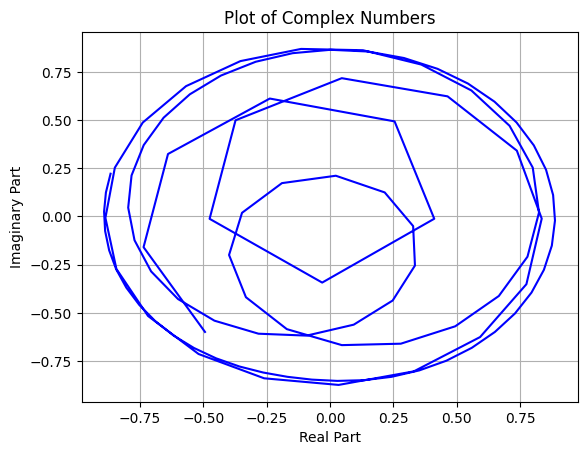

In [171]:
#Boiler plate code for plotting

#complex plot

real_parts = [z.real for z in y_2p_com]
imaginary_parts = [z.imag for z in y_2p_com]

# Plot complex numbers
plt.plot(real_parts[1][:], imaginary_parts[1][:], color='blue')

# Add labels and title
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Plot of Complex Numbers')

# Show plot
plt.grid(True)
#plt.axhline(0, color='black', linewidth=0.5)
#plt.axvline(0, color='black', linewidth=0.5)
plt.show()

C:\Users\alamg\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\alamg\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


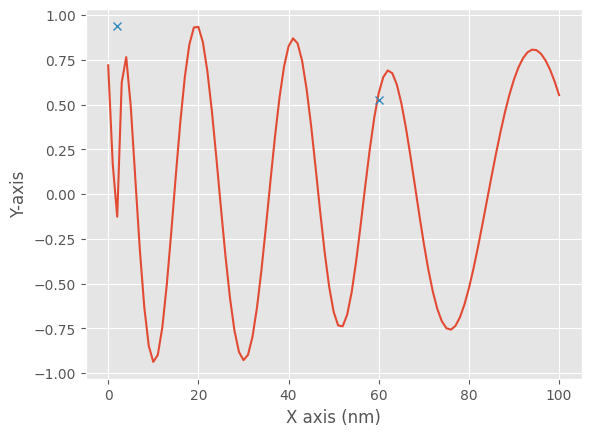

In [173]:
#Boiler plate 

#plot

w4=np.arange(0,101,1)
with plt.style.context('ggplot'): #sanity check if correct waveforms are loaded
    plt.plot(w4,y_2p_com[0,:])
    plt.plot(dP2[0], dA2[0], "x")
    #plt.plot(w3,y_2p_wav[1,:])
    plt.xlabel("X axis (nm)")
    plt.ylabel("Y-axis")
    plt.show()

In [ ]:
#plotting for 202 data points
real_part = predictions[:,0:101]
imaginary_part =predictions[:,101:202]

real_parts = y_test[:,0:101]
imaginary_parts = y_test[:,101:202]

# Plot complex numbers
plt.plot(real_part[0,:], imaginary_part[0,:], color='black')

# Plot complex numbers
plt.plot(real_parts[0,:], imaginary_parts[0,:], color='red')

# Add labels and title
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Plot of Complex Numbers')

# Show plot
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [ ]:
#plotting of Q-factor, Peaks, Amp
num_samples_to_plot = 3
wavelengths_data = pd.DataFrame(np.linspace(1,2,2))
Parameters = wavelengths_data.values.flatten()
plt.figure(figsize=(12, 5))



for i in range(num_samples_to_plot):
    plt.subplot(3, num_samples_to_plot, i + 1)
    plt.scatter(Parameters, y_testp[i], label='True')
    plt.scatter(Parameters, predictionsp[i], label='Predicted')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Peaks')
    plt.ylabel('Peak Position')
    plt.ylim(0, 1)
    plt.legend()


num_samples_to_plot = 3
wavelengths_data = pd.DataFrame(np.linspace(1,2,2))
Parameters = wavelengths_data.values.flatten()
plt.figure(figsize=(12, 5))

for i in range(num_samples_to_plot):
    plt.subplot(3, num_samples_to_plot, i + 1)
    plt.scatter(Parameters, y_testA[i], label='True')
    plt.scatter(Parameters, predictionsA[i], label='Predicted')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Amplitude')
    plt.ylabel('Amplitude Value')
    plt.ylim(0, 1.2)
    plt.legend()

num_samples_to_plot = 3
wavelengths_data = pd.DataFrame(np.linspace(1,2,2))
Parameters = wavelengths_data.values.flatten()
plt.figure(figsize=(12, 5))

for i in range(num_samples_to_plot):
    plt.subplot(3, num_samples_to_plot, i + 1)
    plt.scatter(Parameters, y_testq[i], label='True')
    plt.scatter(Parameters, predictionsq[i], label='Predicted')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Peak No')
    plt.ylabel('Q-Factor Scaled')
    plt.ylim(0, 0.5)
    plt.legend()


# Plot the MSE error for each sample


    
plt.tight_layout()
plt.show()

# Plot the MSE error for each sample
mse_errors = ((predictions - y_test)**2).mean(axis=1)

plt.subplot(3, 1, 3)
plt.bar(range(len(mse_errors)), mse_errors)
plt.xlabel('Sample Index')
plt.ylabel('MSE Error')
plt.title('MSE Error for Test Samples')